In [1]:
import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader,TensorDataset
import numpy
import pandas as pd
import os
import h5py
import re

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score


## Data preprocess

In [2]:
import torch
import h5py
import numpy


def read_rawdata(row_idx: int,col_names: list)-> numpy.ndarray:
    """
    @Description:
    To read the data from h5 file and normalize the features and labels.
    @Parameters:
    Row_idx: the index of row. data type is int
    Col_names: the names of columns. data type is string
    
    """
    with h5py.File('raw_datasets.hdf5', 'r') as fd:
        ## The coloms of the features and labels
        keys=list(fd.keys())
        columns=fd[keys[0]].attrs.get('columns')
        col_idxs=[]
        for col_name in col_names:
            col_idxs.append(np.argwhere(columns==col_name)[0][0])
        
        data_len_list=[]
        for idx in range(len(fd.keys())):
            key="sub_"+str(idx)
            #print(key)
            data_len_list.append(len(fd[key]))
        
        data_len_list_sum=[]
        sum_num=0
        for num in data_len_list:
            sum_num+=num
            data_len_list_sum.append(sum_num)
        
        data_len_list_sum=np.array(data_len_list_sum)
        
        sub_idx=np.argwhere(data_len_list_sum > row_idx)[0,0]
        if(sub_idx>0):
            row_idx=row_idx-data_len_list_sum[sub_idx-1]
            
        return fd['sub_'+str(sub_idx)][row_idx,col_idxs]
    
    

def normalization_parameters(row_idx,col_names):
    with h5py.File('raw_datasets.hdf5', 'r') as fd:
        keys=list(fd.keys())# the keys/columns name of the datafile 
        columns=fd[keys[0]].attrs.get('columns')
        col_idxs=[]
        for col_name in col_names:
            col_idxs.append(np.argwhere(columns==col_name)[0][0])
    
        data_len_list=[]
        for idx in range(len(fd.keys())):
            key="sub_"+str(idx)
            data_len_list.append(len(fd[key]))
    
        data_len_list_sum=[]
        sum_num=0
        for num in data_len_list:
            sum_num+=num
            data_len_list_sum.append(sum_num)
    
        data_len_list_sum=np.array(data_len_list_sum)
    
        sub_idx=np.argwhere(data_len_list_sum > row_idx)[0,0]
        if(sub_idx>0):
            row_idx=row_idx-data_len_list_sum[sub_idx-1]
            sub_idx=np.argwhere(data_len_list_sum > row_idx)[0,0]
            if(sub_idx>0):
                row_idx=row_idx-data_len_list_sum[sub_idx-1]
        
        mean=np.mean(fd['sub_'+str(sub_idx)][:,col_idxs],axis=0,keepdims=True)
        std=np.std(fd['sub_'+str(sub_idx)][:,col_idxs],axis=0,keepdims=True)
        data_mean=pd.DataFrame(data=mean,columns=col_names)
        data_std=pd.DataFrame(data=std,columns=col_names)
        return data_mean, data_std    
        

features_names=['L_Up_Quat_q0', 'L_Up_Quat_q1', 'L_Up_Quat_q2', 'L_Up_Quat_q3','L_Lower_Quat_q0', 'L_Lower_Quat_q1', 'L_Lower_Quat_q2', 'L_Lower_Quat_q3']
print(read_rawdata(20000,['R_IE']))
data_mean, data_std = normalization_parameters(200,features_names)    
print(data_std)

[-1.79476622]
   L_Up_Quat_q0  L_Up_Quat_q1  L_Up_Quat_q2  L_Up_Quat_q3  L_Lower_Quat_q0  \
0      0.054888      0.098097      0.076217      0.132996         0.031749   

   L_Lower_Quat_q1  L_Lower_Quat_q2  L_Lower_Quat_q3  
0         0.123713          0.05695          0.10984  


## Dataset class

In [3]:
#用某日前8天窗口数据作为输入预测该日数据
class DroplandingDataset(torch.utils.data.Dataset):
    def __init__(self,datafile,features_names,labels_names,train=True):
        with h5py.File(datafile,'r') as fd:
            keys=fd.keys()
            ## features and labels
            keys=list(fd.keys())
            #print(f.attrs["columns"]
            columns=fd[keys[0]].attrs.get('columns')
            '''
            features_names=['L_Up_Quat_q0', 'L_Up_Quat_q1', 'L_Up_Quat_q2', 'L_Up_Quat_q3',
                        'L_Lower_Quat_q0', 'L_Lower_Quat_q1', 'L_Lower_Quat_q2', 'L_Lower_Quat_q3']
            labels_names=['R_IE']
            '''
            
            # 16 features and 6 lables/targets
            # features and labels idx
            features_idx=[]
            labels_idx=[]
            for f_name in features_names:
                features_idx.append(np.argwhere(columns==f_name)[0,0])
            for l_name in labels_names:
                labels_idx.append(np.argwhere(columns==l_name)[0,0])
                
            #row_length and row_idx
            data_len_list=[]
            self.all_datasets={}
            for idx in range(len(fd.keys())):
                key="sub_"+str(idx)
                data_len_list.append(len(fd[key]))
                temp_data=np.array(fd[key])
                #Normalization maunually or by sci-kit learn tools 正则化
                temp_mean = np.mean(temp_data,axis=0,keepdims=True)
                temp_std = np.std(temp_data,axis=0,keepdims=True)
                temp_data=(temp_data-temp_mean)/temp_std
                self.all_datasets[key]=temp_data
                
            
            #summary data length
            data_len_list_sum=[]
            sum_num=0
            for num in data_len_list:
                sum_num+=num
                data_len_list_sum.append(sum_num)
        
            data_len_list_sum=np.array(data_len_list_sum)
            
            #class attrs
            self.data_len=sum_num
            self.features_idx=features_idx
            self.labels_idx=labels_idx
            self.data_len_list_sum=data_len_list_sum
        
        
    def __len__(self):
        #print(self.data_len)
        return self.data_len

    def __getitem__(self,row_idx):       
        #The index of the subjects 
        sub_idx=np.argwhere(self.data_len_list_sum>row_idx)[0,0]
        if(sub_idx>0):
            row_idx=row_idx-self.data_len_list_sum[sub_idx-1]
        
        #Features and labels
        features = self.all_datasets['sub_'+str(sub_idx)][row_idx,self.features_idx]
        labels = self.all_datasets['sub_'+str(sub_idx)][row_idx,self.labels_idx]    
        
        #print("feature type:{} and shape:{}".format(type(features),features.shape))
        return (torch.from_numpy(features).to(torch.float32),torch.from_numpy(labels).to(torch.float32))




#数据较小，可以将全部训练数据放入到一个batch中，提升性能

In [4]:
import torchvision.transforms as transforms

h5format_dataset="raw_datasets.hdf5"

transforms_dic={"features": transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.0)*16,(1.0)*16)]),
               "labels": transforms.Compose([transforms.ToTensor,transforms.Normalize((0.0)*6,(1.0)*6)])}
#datasets = DroplandingDataset(h5format_dataset,transform=transforms_dic['features'],target_transform=transforms_dic['labels'])

features_names=['L_Up_Quat_q0', 'L_Up_Quat_q1', 'L_Up_Quat_q2', 'L_Up_Quat_q3',
                        'L_Lower_Quat_q0', 'L_Lower_Quat_q1', 'L_Lower_Quat_q2', 'L_Lower_Quat_q3',
                        'R_Up_Quat_q0', 'R_Up_Quat_q1', 'R_Up_Quat_q2', 'R_Up_Quat_q3',
                       'R_Lower_Quat_q0', 'R_Lower_Quat_q1', 'R_Lower_Quat_q2', 'R_Lower_Quat_q3']
labels_names=['R_IE', 'R_AA', 'R_FE', 'L_IE', 'L_AA', 'L_FE']

datasets=DroplandingDataset(h5format_dataset,features_names,labels_names)
train_sets, val_sets, test_sets=torch.utils.data.random_split(datasets,[50000,10000,36983])
print("db1:",len(train_sets),"db2:",len(val_sets),"db3:",len(test_sets))
batch_size=2
#pdb.set_trace()
# 创建数据集的可迭代对象，并且分批、打乱数据集
train_loader = torch.utils.data.DataLoader(dataset=train_sets, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_sets, batch_size=batch_size, shuffle=True)

print(train_loader.dataset)
print(next(iter(train_loader.dataset)))

db1: 50000 db2: 10000 db3: 36983
(tensor([-1.6803, -1.5251, -1.0952, -0.6839,  0.3138, -1.4842,  1.3588, -1.1769,
        -1.2196, -0.7489,  1.5130, -1.8104,  1.4317,  0.8999, -1.8080,  2.4890]), tensor([ 1.3567, -0.1019,  0.2192, -0.0622, -2.0871,  0.8768]))


### Forward neural network

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class MyFNN_Model(nn.Module):
    def __init__(self,num_features, num_labels):
        super(MyFNN_Model,self).__init__()
        self.fc1=nn.Linear(num_features,100)
        self.fc2=nn.Linear(100,50)
        self.fc3=nn.Linear(50,20)
        self.fc4=nn.Linear(20,num_labels)
        self.func=nn.Tanh()
        
    def forward(self,x):# batch_size, sequence, input_size=features_dim
        y0=self.fc1(x)
        y1=self.func(y0)
        y2=F.dropout(y1,training=self.training)
        
        y3=self.fc2(y2)
        y4=self.func(y3)
        y5=F.dropout(y4,training=self.training)
        
        y6=self.fc3(y5)
        y7=self.func(y6)
        y8=F.dropout(y7,training=self.training)
        
        y9=self.fc4(y8)
        y10=y9
        #y10=self.func(y9)
        #y11=F.dropout(y10,training=self.training)
        return y10

## Training: FNN

In [13]:
# Declare super parameters
# Two legs's knee angles, right: interal rotation, abduction, flexion as well as left size: ...
import matplotlib.pyplot as plt
batch_size=100
epochs=1000
learning_rate=0.00001

device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

h5format_dataset="raw_datasets.hdf5"

"""
features_names=['L_Up_Quat_q0', 'L_Up_Quat_q1', 'L_Up_Quat_q2', 'L_Up_Quat_q3',
                        'L_Lower_Quat_q0', 'L_Lower_Quat_q1', 'L_Lower_Quat_q2', 'L_Lower_Quat_q3',
                        'R_Up_Quat_q0', 'R_Up_Quat_q1', 'R_Up_Quat_q2', 'R_Up_Quat_q3',
                       'R_Lower_Quat_q0', 'R_Lower_Quat_q1', 'R_Lower_Quat_q2', 'R_Lower_Quat_q3']
"""
##labels_names=['R_IE', 'R_AA', 'R_FE', 'L_IE', 'L_AA', 'L_FE']
labels_names=['R_FE']
features_names=['L_Up_Acc_X', 'L_Up_Acc_Y', 'L_Up_Acc_Z', 'L_Up_Gyr_X', 'L_Up_Gyr_Y','L_Up_Gyr_Z',
'L_Lower_Acc_X', 'L_Lower_Acc_Y', 'L_Lower_Acc_Z', 'L_Lower_Gyr_X', 'L_Lower_Gyr_Y','L_Lower_Gyr_Z',
'R_Up_Acc_X', 'R_Up_Acc_Y', 'R_Up_Acc_Z', 'R_Up_Gyr_X', 'R_Up_Gyr_Y','R_Up_Gyr_Z',
'R_Lower_Acc_X', 'R_Lower_Acc_Y', 'R_Lower_Acc_Z', 'R_Lower_Gyr_X', 'R_Lower_Gyr_Y','R_Lower_Gyr_Z']

cuda


In [14]:
## Declare
import os

datasets=DroplandingDataset(h5format_dataset,features_names,labels_names)

train_sets, test_sets, val_sets=torch.utils.data.random_split(datasets,[60000,10000,26983])

# 创建数据集的可迭代对象，并且分批、打乱数据集
train_loader = torch.utils.data.DataLoader(dataset=train_sets, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_sets, batch_size=batch_size, shuffle=True)
#print("train_loader:", next(iter(train_loader)).shape)

num_features=len(features_names)
num_labels=len(labels_names)

model=MyFNN_Model(num_features,num_labels)
if torch.cuda.is_available():
    model = model.cuda()
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
#optimizer=torch.optim.SGD(model.parameters(),lr=learning_rate)

iter=0
loss_list = [] # 保存loss
accuracy_list = [] # 保存accuracy
iteration_list = [] # 保存循环次数
outputs_list=[]

#plt.ion()

for epoch in range(epochs):
    for i, (features, labels) in enumerate(train_loader):
        model.train() # 声明训练
        features=features.to(device)
        labels = labels.to(device)
        # 梯度清零（否则会不断累加）
        optimizer.zero_grad()
        # 前向传播
        #print(" features shape:{}, labels shape:{} ".format(features.shape, labels.shape))
        outputs = model(features)
        #print("outputs shape:{}, labels shape:{} ".format(outputs.shape, labels.shape))
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 计数器自动加1
        iter+=1
        if(iter%1000==0):
            #plt.cla()
            loss_list.append(loss.cpu().detach().numpy())
            iteration_list.append(iter)
            print("epoch: {}, loss: {}".format(epoch,loss.cpu().detach()))
            #Visualization of trainning
            #plt.cla()
            # 无误差真值曲线
            #plt.scatter(features.cpu().numpy()[-1,1], labels.cpu().numpy()[-1,1], c='blue', lw='3')
            # 有误差散点
            #plt.scatter(x_data.numpy(), y_data.numpy(), c='orange')
            # 实时预测的曲线
            #plt.plot(iteration_list,loss_list, c='red', lw='2')
            #plt.text(-0.5, -65, 'Time=%d Loss=%.4f' % (i, loss.cpu().data.numpy()), fontdict={'size': 15, 'color': 'red'})
            #plt.pause(0.01)
            
rename_file="fnn_model_parameters.pk1"
if(os.path.exists(rename_file)):
    os.remove(rename_file)
torch.save(model.state_dict(),rename_file)



epoch: 1, loss: 0.5825323462486267
epoch: 3, loss: 0.6242890954017639
epoch: 4, loss: 0.5089030265808105
epoch: 6, loss: 0.43830999732017517
epoch: 8, loss: 0.3377300500869751
epoch: 9, loss: 0.34780699014663696
epoch: 11, loss: 0.3442181646823883
epoch: 13, loss: 0.4449857175350189
epoch: 14, loss: 0.2639532685279846
epoch: 16, loss: 0.43499481678009033
epoch: 18, loss: 0.4677141606807709
epoch: 19, loss: 0.6307927370071411
epoch: 21, loss: 0.40946364402770996
epoch: 23, loss: 0.35035642981529236
epoch: 24, loss: 0.4093080163002014
epoch: 26, loss: 0.21593502163887024
epoch: 28, loss: 0.38611742854118347
epoch: 29, loss: 0.405556857585907
epoch: 31, loss: 0.3169403672218323
epoch: 33, loss: 0.37626802921295166
epoch: 34, loss: 0.3568277657032013
epoch: 36, loss: 0.39532628655433655
epoch: 38, loss: 0.3189440667629242
epoch: 39, loss: 0.2666265666484833
epoch: 41, loss: 0.4887693226337433
epoch: 43, loss: 0.7023125290870667
epoch: 44, loss: 0.34117478132247925
epoch: 46, loss: 0.350326

epoch: 369, loss: 0.2622867226600647
epoch: 371, loss: 0.1816360503435135
epoch: 373, loss: 0.32094404101371765
epoch: 374, loss: 0.22687159478664398
epoch: 376, loss: 0.28223299980163574
epoch: 378, loss: 0.22108443081378937
epoch: 379, loss: 0.3808722496032715
epoch: 381, loss: 0.2430439293384552
epoch: 383, loss: 0.3658277094364166
epoch: 384, loss: 0.19600163400173187
epoch: 386, loss: 0.292203813791275
epoch: 388, loss: 0.21625883877277374
epoch: 389, loss: 0.2505204379558563
epoch: 391, loss: 0.2870860695838928
epoch: 393, loss: 0.24877242743968964
epoch: 394, loss: 0.20567703247070312
epoch: 396, loss: 0.17197296023368835
epoch: 398, loss: 0.2575733959674835
epoch: 399, loss: 0.22461245954036713
epoch: 401, loss: 0.20170865952968597
epoch: 403, loss: 0.3011949360370636
epoch: 404, loss: 0.2657153606414795
epoch: 406, loss: 0.18588756024837494
epoch: 408, loss: 0.24101553857326508
epoch: 409, loss: 0.305482417345047
epoch: 411, loss: 0.19558067619800568
epoch: 413, loss: 0.212488

epoch: 734, loss: 0.29359933733940125
epoch: 736, loss: 0.23883646726608276
epoch: 738, loss: 0.22000080347061157
epoch: 739, loss: 0.15196023881435394
epoch: 741, loss: 0.1655951291322708
epoch: 743, loss: 0.1434149146080017
epoch: 744, loss: 0.18458396196365356
epoch: 746, loss: 0.22544433176517487
epoch: 748, loss: 0.2626582384109497
epoch: 749, loss: 0.28369778394699097
epoch: 751, loss: 0.2711268663406372
epoch: 753, loss: 0.18453314900398254
epoch: 754, loss: 0.17682017385959625
epoch: 756, loss: 0.18766795098781586
epoch: 758, loss: 0.15394414961338043
epoch: 759, loss: 0.17214937508106232
epoch: 761, loss: 0.19226695597171783
epoch: 763, loss: 0.22768568992614746
epoch: 764, loss: 0.17106269299983978
epoch: 766, loss: 0.24220848083496094
epoch: 768, loss: 0.19178493320941925
epoch: 769, loss: 0.2208012342453003
epoch: 771, loss: 0.14901135861873627
epoch: 773, loss: 0.24454562366008759
epoch: 774, loss: 0.1233142837882042
epoch: 776, loss: 0.25416049361228943
epoch: 778, loss: 

### Prediction : FNN

In [15]:
## new model and load the trained model parameters
import numpy as np
import torch
import h5py

trained_model=MyFNN_Model(num_features,num_labels)
model_state_dic=torch.load("fnn_model_parameters.pk1")
trained_model.load_state_dict(model_state_dic)

predictions=[]
labels=[]
features=[]
row_idx_start=11000
row_idx_end=11500
fea_data_mean,fea_data_std=normalization_parameters(row_idx_start,features_names)
lab_data_mean,lab_data_std=normalization_parameters(row_idx_start,labels_names)

for idx in range(row_idx_start,row_idx_end):
    with torch.no_grad():
        trained_model.eval()
        trained_model.to(device)
        fea_temp=read_rawdata(idx,features_names)
        features.append(fea_temp)
        fea_temp_norm=(fea_temp-fea_data_mean.values)/fea_data_std.values
        #fea_temp=(read_rawdata(idx,features_names)-fea_data_mean.values)/fea_data_std.values
        #lab_temp=(read_rawdata(idx,labels_names)-lab_data_mean.values)/lab_data_std.values
        lab_temp=read_rawdata(idx,labels_names)
        labels.append(lab_temp)
        fea_temp_norm=torch.from_numpy(fea_temp_norm).unsqueeze_(dim=0).to(torch.float32).to(device)
        pre_temp_norm=trained_model(fea_temp_norm)
        pre_temp=pre_temp_norm.cpu().numpy()*lab_data_std.values+lab_data_std.values
        predictions.append(pre_temp)




## Prediction visualization

Actual labels:
         R_FE
0  61.427350
1  59.505964
2  57.231817
3  54.981885
4  52.576291
Predictions:
         R_FE
0  82.500565
1  82.920938
2  83.632837
3  82.054024
4  77.452883
Error:
         R_FE
0  21.073215
1  23.414973
2  26.401020
3  27.072139
4  24.876592


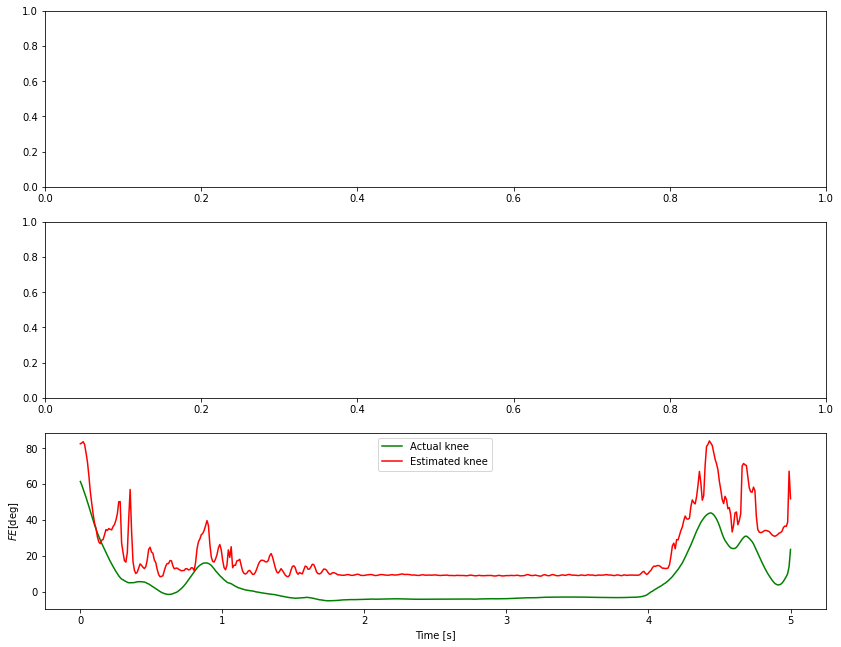

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# features
features=np.squeeze(np.array(features))
# lablels
labels=np.squeeze(np.array(labels))
# predictions
predictions=np.squeeze(np.array(predictions))

# Pandas DataFrame of the above datasets
pd_features=pd.DataFrame(features,columns=features_names)
pd_labels=pd.DataFrame(labels,columns=labels_names)
pd_predictions=pd.DataFrame(data=predictions,columns=labels_names)

#figsize=(8,8)
#fig=plt.figure(figsize=figsize)
#sns.lineplot(data=pd_labels,x=range(pd_labels.shape[0]),y='R_IE')


freq=100.0;
Time=np.linspace(0,labels.shape[0]/freq,num=labels.shape[0])
figsize=(14,11)
fig=plt.figure(figsize=figsize)
axs=fig.subplots(3,1)
"""

axs[0].plot(Time,pd_labels['R_IE'],"g")
axs[0].plot(Time, pd_predictions['R_IE'],"r")
axs[0].legend(['Actual knee','Estimated knee'])
axs[0].set_xlabel("Time [s]")
axs[0].set_ylabel(u"$IE [\deg]$")

axs[1].plot(Time,pd_labels['R_AA'],"g")
axs[1].plot(Time,pd_predictions['R_AA'],"r")
axs[1].legend(['Actual knee','Estimated knee'])
axs[1].set_xlabel("Time [s]")
axs[1].set_ylabel(u"$AA [\deg]$")
"""

axs[2].plot(Time, pd_labels['R_FE'],"g")
axs[2].plot(Time, pd_predictions['R_FE'],"r")
axs[2].legend(['Actual knee','Estimated knee'])
axs[2].set_xlabel("Time [s]")
axs[2].set_ylabel(u"$FE [\deg]$")


#ESM
R_IE_error=pd_predictions-pd_labels
print("Actual labels:\n",pd_labels.head())
print("Predictions:\n",pd_predictions.head())
print("Error:\n",R_IE_error.head())

## LSTM V1.0 Model

In [10]:

import torch.nn as nn
class MyLSTM_Model(nn.Module):
    def __init__(self,input_dim,hidden_dim,layer_dim,output_dim):
        super(MyLSTM_Model,self).__init__()
        self.input_dim=input_dim
        self.hidden_dim=hidden_dim
        self.layer_dim=layer_dim
        self.output_dim=output_dim
        
        self.bn1 = nn.BatchNorm1d(input_dim)
        self.lstm=nn.LSTM(self.input_dim,self.hidden_dim,self.layer_dim,batch_first=True)
        self.fc=nn.Linear(hidden_dim,output_dim) #(16,6)
        
    def forward(self,x):# batch_size, sequence, input_size=features_dim
        # (layer_dim, batch_size, hidden_dim)
        h0=torch.zeros(self.layer_dim,x.size(0),self.hidden_dim).to(device)
        c0=torch.zeros(self.layer_dim,x.size(0),self.hidden_dim).to(device)
        out,(hn,cn)=self.lstm(x,(h0.detach(),c0.detach()))
        print("out shape:",out.shape)
        results=self.fc(out[:,-1,:])# batch size=10, sequence_dim (1),hidden_dim (16)
        return results
    

## LSTM V2.0 Model

In [11]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, dropout=0.2):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.rnn = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=1,
            dropout=dropout,
            bidirectional=False, )
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        batch_size = x.size()[0]
        seq_length = x.size()[1]

        x = x.view(seq_length, batch_size, -1)

        # We need to pass the initial cell states
        h0 = Variable(torch.zeros(seq_length, batch_size, self.hidden_size))
        c0 = Variable(torch.zeros(seq_length, batch_size, self.hidden_size))
        outputs, (ht, ct) = self.rnn(x, (h0, c0))

        out = outputs[-1]  # We are only interested in the final prediction
        out = self.bn1(self.fc1(out))
        out = self.relu(out)
        out = F.dropout(out, training=self.training)
        out = self.fc2(out)
        return out

## Training: LSTM model 

In [12]:
import torchvision.transforms as transforms
import pdb
# Declare super parameters
output_dim=1 # two legs's knee angles, right: interal rotation, abduction, flexion as well as left size: ...
input_dim=8
layer_dim=2
hidden_dim=8
batch_size=20
epochs=5
sequence_dim=1
learning_rate=0.01

device=torch.device("gpu" if torch.cuda.is_available() else "cpu")

h5format_dataset="raw_datasets.hdf5"
transforms_dic={"features": transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.0,),(1.0,))]),
               "labels": transforms.Compose([transforms.ToTensor,transforms.Normalize((0.0,),(1.0,))])}
#datasets = DroplandingDataset(h5format_dataset,transform=transforms_dic['features'],target_transform=transforms_dic['labels'])
datasets=DroplandingDataset(h5format_dataset)

train_sets, val_sets, test_sets=torch.utils.data.random_split(datasets,[50000,10000,36983])
#print("db1:",len(train_sets),"db2:",len(val_sets),"db3:",len(test_sets))
#print(train_sets.dataset)

#pdb.set_trace()
# 创建数据集的可迭代对象，并且分批、打乱数据集
train_loader = torch.utils.data.DataLoader(dataset=train_sets, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_sets, batch_size=batch_size, shuffle=True)
#print("train_loader:", next(iter(train_loader)).shape)

#model=MyLSTM_Model(input_dim,hidden_dim,layer_dim,output_dim)
model=MyFNN_Model(input_dim)
criterion=nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)

iter=0

loss_list = [] # 保存loss
accuracy_list = [] # 保存accuracy
iteration_list = [] # 保存循环次数

for epoch in range(epochs):
    for i, (features, labels) in enumerate(train_loader):
        model.train() # 声明训练
        # 一个batch的数据转换为RNN的输入维度
        #features = features.view(-1, sequence_dim, input_dim).requires_grad_().to(device) 
        features=features.to(device)
        labels = labels.to(device)
        # 梯度清零（否则会不断累加）
        optimizer.zero_grad()
        # 前向传播
        #print(" features shape:{}, labels shape:{} ".format(features.shape, labels.shape))
        outputs = model(features)
        #print("outputs shape:{}, labels shape:{} ".format(outputs.shape, labels.shape))
        # 计算损失
        loss = criterion(outputs, labels)
        # 反向传播
        loss.backward()
        # 更新参数
        optimizer.step()
        # 计数器自动加1
        iter += 1
        # 模型验证
        if iter % 500 == 0:
            model.eval() # 声明
            # 计算验证的accuracy
            correct = 0.0
            total = 0.0
            # 迭代测试集，获取数据、预测
            for features,labels in test_loader:
                features = features.to(device) 
                # 模型预测
                outputs = model(features)
                # 获取预测概率最大值的下标
                #predict = torch.max(outputs.data, 1)[1]
                # 统计测试集的大小
                #total += labels.size(0)
                # 统计判断/预测正确的数量
                if torch.cuda.is_available():
                    correct += (outputs.gpu() == labels.gpu()).sum()
                else:
                    correct += (outputs == labels).sum()
            # 计算
            accuracy = correct / total * 100
            # 保存accuracy, loss, iteration
            loss_list.append(loss.data)
            accuracy_list.append(accuracy)
            iteration_list.append(iter)
            # 打印信息
            print("loop : {}, Loss : {}, Accuracy : {}".format(iter, loss.item(), accuracy))
    

RuntimeError: Expected one of cpu, cuda, xpu, mkldnn, opengl, opencl, ideep, hip, msnpu, mlc, xla, vulkan, meta, hpu device type at start of device string: gpu